# Language Classification with Naive Bayes in Python

## Recommended Prerequisites for Successful Completion
* Intermediate level understanding of Python 3+ (e.g. list and dictionary comprehension)
* Basics of machine learning (e.g. the distinction between training and validation data)
* Mathematical probability (e.g. understanding Bayes' Theorem at a basic level)


## Project Outline
[**Introduction**](#intro)

[**Task 1**](#task1): Exploratory Data Analysis + Visualization

[**Task 2**](#task2): Data Cleaning and Preprocessing

[**Task 3**](#task3): Naive Bayes Model Introduction and Training

[**Task 4**](#task4): Highlighting Problems with Basic Model and Simple Fixes

[**Task 5**](#task5): Advanced Approach to Further Improve Performance

In [2]:
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import numpy as np
import string

from collections import defaultdict

from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

import joblib
import pickle as pkl

from helper_code import *

<a id='intro'></a>
# Introduction

In [102]:
model =joblib.load('Data/Models/final_model.joblib')
vectorizer = joblib.load('Data/Vectorizers/final_model.joblib')

## [Slovak Wikipedia Entry](https://sk.wikipedia.org/wiki/Jazveč%C3%ADk)
Mnohí ľudia, ktorí vidia na ulici jazvečíka s podlhovastým telom vôbec nevedia o tom, že tento malý štvornohý a veľmi obľúbený spoločník je pri dobrom výcviku obratným, vynikajúcim a spoľahlivým poľovným psom. Ako poľovný pes je mnohostranne využiteľný, okrem iného ako durič na brlohárenie. Králičí jazvečík sa dokáže obratne pohybovať v králičej nore. S inými psami a deťmi si nie vždy rozumie.

## [Czech Wikipedia Entry](https://cs.wikipedia.org/wiki/Jezevč%C3%ADk)
Úplně první zmínky o psech podobných dnešním jezevčíkům nacházíme až ve Starém Egyptě, kde jsou vyobrazeni na soškách a rytinách krátkonozí psi s dlouhým hřbetem a krátkou srstí. Jednalo se ale o neustálený typ bez ustáleného jména. Další zmínky o jezevčících nacházíme až ve 14 - 15. století. Jedná se o psa, který se nejvíce podobá dnešnímu typu hladkosrstého standardního jezevčíka.


## [English Wikipedia Entry](https://en.wikipedia.org/wiki/Dachshund)
While classified in the hound group or scent hound group in the United States and Great Britain, the breed has its own group in the countries which belong to the Fédération Cynologique Internationale (World Canine Federation). Many dachshunds, especially the wire-haired subtype, may exhibit behavior and appearance that are similar to that of the terrier group of dogs.

In [103]:
text = 'okrem iného ako durič na brlohárenie'
text = 'This is a project'
text = 'Dobré'
text = preprocess_function(text)
text = [split_into_subwords_function(text)]
text_vectorized = vectorizer.transform(text)

print(model.predict(text_vectorized))

['cs']


<a id='task1'></a>
# Task 1: Data Exploration and Visualization

In [5]:
def open_file(filename):
    with open(filename, 'r') as f:
        data = f.readlines()
    return data

In [6]:
data_raw = dict()
data_raw['sk'] = open_file('Data/Sentences/train_sentences.sk')
data_raw['cs'] = open_file('Data/Sentences/train_sentences.cs')
data_raw['en'] = open_file('Data/Sentences/train_sentences.en')

In [7]:
def show_statistics(data):
    for language, sentences in data.items():
        
        number_of_sentences = 0
        number_of_words = 0
        number_of_unique_words = 0
        sample_extract = ''
        
        # take a few minutes to try populate these variables
        
        # here is a hint -- word_list breaks the collections of sentences into a list of words
        word_list = ' '.join(sentences).split()
        
        number_of_sentences = len(sentences)
        number_of_words = len(word_list)
        number_of_unique_words = len(set(word_list))
        sample_extract = ' '.join(sentences[0].split()[0:7])
        
        
        print(f'Language: {language}')
        print('-----------------------')
        print(f'Number of sentences\t:\t {number_of_sentences}')
        print(f'Number of words\t\t:\t {number_of_words}')
        print(f'Number of unique words\t:\t {number_of_unique_words}')
        print(f'Sample extract\t\t:\t {sample_extract}...\n')

In [8]:
show_statistics(data_raw)

Language: sk
-----------------------
Number of sentences	:	 100
Number of words		:	 2016
Number of unique words	:	 1322
Sample extract		:	 Pán de Grandes Pascual jasne vysvetlil, aká...

Language: cs
-----------------------
Number of sentences	:	 10
Number of words		:	 158
Number of unique words	:	 141
Sample extract		:	 Upozorňujeme, že jejím cílem je šetřit penězi...

Language: en
-----------------------
Number of sentences	:	 100
Number of words		:	 2381
Number of unique words	:	 1037
Sample extract		:	 I can understand your approach a little...



In [108]:
data_raw.items()

dict_items([('sk', ['Pán de Grandes Pascual jasne vysvetlil, aká je pridaná hodnota definície terorizmu, vyjadrením, že definícia, ktorú sme používali predtým, bola dôležitejšia, ale aj tým, že trval na zozname priestupkov.\n', 'Keby sme sa nepokúsili o nemožné, ako by sme mohli dosiahnuť zmenu?\n', 'Oznámil, že budúci týždeň sa zúčastní schôdze Výboru pre zahraničné veci.\n', 'Niekedy by sa mohlo zdať, že ide o hru alebo pokrytectvo.\n', 'Jej účelom je tiež identifikovať akékoľvek slabé miesta v systéme a právne nedostatky súdnej spolupráce v trestných veciach, aby sa európskym zákonodarcom poskytli všetky informácie potrebné na správne politické a regulačné hodnotenie.\n', 'Na dosiahnutie tohto cieľa je mimoriadne dôležité, aby členské štáty zaviedli prijaté opatrenia a úzko spolupracovali.\n', '(FR) Pani predsedajúca, pán predseda Barroso nám stanovil náročný cieľ v oblasti výroby obnoviteľnej energie s cieľom znížiť emisie skleníkových plynov bez toho, aby sa brzdili naše vyhliadky

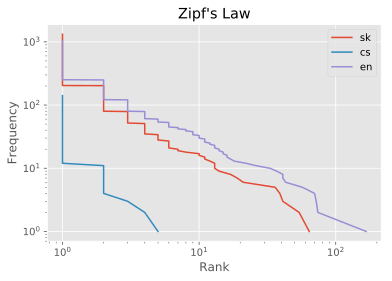

In [9]:
do_law_of_zipf(data_raw)

<a id='task2'></a>
# Task 2: Data Cleaning and Preprocessing

In [10]:
'''
Removes punctuation and digits from a string, and converts all characters to lowercase. 
Also clears all \n and hyphens (splits hyphenated words into two words).
'''   
def preprocess(text): 
    preprocessed_text = text  
    preprocessed_text = text.lower().replace('-', ' ')
    translation_table = str.maketrans('\n', ' ', string.punctuation+string.digits)
    preprocessed_text = preprocessed_text.translate(translation_table)
    return preprocessed_text

In [11]:
data_preprocessed = {k: [preprocess(sentence) for sentence in v] for k, v in data_raw.items()}

In [12]:
show_statistics(data_raw)

print('\nPreprocessed data')
show_statistics(data_preprocessed)

Language: sk
-----------------------
Number of sentences	:	 100
Number of words		:	 2016
Number of unique words	:	 1322
Sample extract		:	 Pán de Grandes Pascual jasne vysvetlil, aká...

Language: cs
-----------------------
Number of sentences	:	 10
Number of words		:	 158
Number of unique words	:	 141
Sample extract		:	 Upozorňujeme, že jejím cílem je šetřit penězi...

Language: en
-----------------------
Number of sentences	:	 100
Number of words		:	 2381
Number of unique words	:	 1037
Sample extract		:	 I can understand your approach a little...


Preprocessed data
Language: sk
-----------------------
Number of sentences	:	 100
Number of words		:	 1996
Number of unique words	:	 1207
Sample extract		:	 pán de grandes pascual jasne vysvetlil aká...

Language: cs
-----------------------
Number of sentences	:	 10
Number of words		:	 155
Number of unique words	:	 133
Sample extract		:	 upozorňujeme že jejím cílem je šetřit penězi...

Language: en
-----------------------
Number of sentenc

<a id='task3'></a>
# Task 3: The Naive Bayes Model

**Bayes' Theorem**

\begin{equation}
P(A | B)=\frac{P(B | A) \times P(A)}{P(B)}
\end{equation}

Now, let's translate this theory into our specific problem. In our case, where we want to categorise a sentence `my name is Ari` into one of `sk`, `cs`, or `en`, the following are the probabilities we want to determine.

\begin{equation}
P(\text {sk} | \text {my name is Ari})=\frac{P(\text {my name is Ari} | \text {sk}) \times P(\text {sk})}{P(\text {my name is Ari})}
\end{equation}

\begin{equation}
P(\text {cs} | \text {my name is Ari})=\frac{P(\text {my name is Ari} | \text {cs}) \times P(\text {cs})}{P(\text {my name is Ari})}
\end{equation}

\begin{equation}
P(\text {en} | \text {my name is Ari})=\frac{P(\text {my name is Ari} | \text {en}) \times P(\text {en})}{P(\text {my name is Ari})}
\end{equation}

## Unseen Data

Since we assume conditional independence across our features, our numerator term for any of the above equations can be broken into the following.

\begin{equation}
P(\text {my name is Ari} | \text {en}) = P(\text {my} | \text {en}) \times P(\text {name} | \text {en}) \times P(\text {is} | \text {en}) \times P(\text {Ari} | \text {en})
\end{equation}

## Vectorizing Training Data

|Sentence   	||   my   	| is 	| I 	| love 	| name 	| it 	| Ari 	|
|-----------------	||:------:	|:--:	|:-:	|:----:	|:----:	|:--------:	|:---:	|
| my name is Ari  	||    1   	|  1 	| 0 	|   0  	|   1  	|     0    	|  1  	|
| I love it 	||    0   	|  0 	| 1 	|   1  	|   0  	|     1    	|  0  	|

In [23]:
sentences_train,y_train = [],[]

for k,v in data_preprocessed.items():
    for sentence in v:
        sentences_train.append(sentence)
        y_train.append(k)

In [24]:
vectorizer = CountVectorizer()

In [25]:
x_train=vectorizer.fit_transform(sentences_train)

## Initializing Model Parameters and Training

In [39]:
naive_classifier = MultinomialNB()
naive_classifier.fit(x_train,y_train)

MultinomialNB()

## Vectorizing Validation Data and Evaluating Model

In [122]:
data_val = dict()
data_val['sk'] = open_file('Data/Sentences/val_sentences.sk')
data_val['cs'] = open_file('Data/Sentences/val_sentences.cs')
data_val['en'] = open_file('Data/Sentences/val_sentences.en')
show_statistics(data_val)
data_val_preprocessed = {k: [preprocess(sentence) for sentence in v ] for k, v in data_val.items()} 


Language: sk
-----------------------
Number of sentences	:	 5000
Number of words		:	 100074
Number of unique words	:	 23817
Sample extract		:	 Environmentálne hodnotenie zlučiteľnosti v počiatočnej fáze, pri...

Language: cs
-----------------------
Number of sentences	:	 5000
Number of words		:	 99639
Number of unique words	:	 23293
Sample extract		:	 Souhlasím s ustanovením uvedeným v usnesení, že...

Language: en
-----------------------
Number of sentences	:	 5000
Number of words		:	 119231
Number of unique words	:	 14035
Sample extract		:	 The Council therefore has no competence to...



In [123]:
%data_val_preprocessed = {k: [preprocess(sentence) for sentence in v] for k, v in data_val.items()}

UsageError: Line magic function `%data_val_preprocessed` not found.


In [124]:
sentences_val, y_val = [], []

for k, v in data_val_preprocessed.items():
    for sentence in v:
        sentences_val.append(sentence)
        y_val.append(k)

In [125]:
x_val = vectorizer.transform(sentences_val)

In [126]:
naive_classifier = MultinomialNB()
naive_classifier.fit(x_val,y_val)

MultinomialNB()

In [127]:
predictions = naive_classifier.predict(x_train)

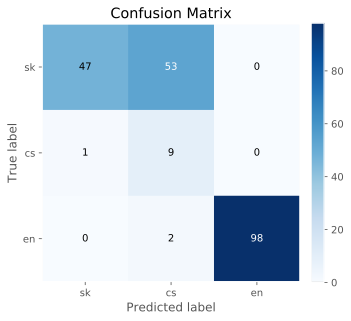

In [128]:
plot_confusion_matrix(y_train, predictions, ['sk', 'cs', 'en'])

In [62]:
f1_score(y_train,predictions,average='weighted')

0.9865371882586625

In [63]:
joblib.dump(naive_classifier, 'Data/Models/final_model.joblib')
joblib.dump(vectorizer, 'Data/Vectorizers/final_model.joblib')


['Data/Vectorizers/final_model.joblib']

<a id='task4'></a>
# Task 4: Simple Adjustments and Highlighting Model Shortcomings

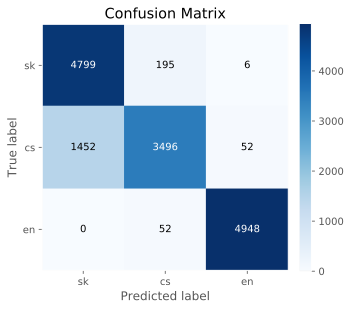

In [48]:
naive_classifier = MultinomialNB(alpha=0.04, fit_prior=False)
naive_classifier.fit(x_train,y_train)

predictions = naive_classifier.predict(x_val)

plot_confusion_matrix(y_val,predictions, ['sk','cs','en'])

In [49]:
f1_score(y_val,predictions,average='weighted')

0.88060393899013

<a id='task5'></a>
# Task 5: Using Subwords to Shift Perspective

**Dummy Dataset**

playing ; eating ; play ; reads ; tea

**Step 1**

Break each word into characters

playing > p l a y i n g


**Step 2**

Find common character sequences

ea, ing, play

**Step 3**

Convert dataset using these subwords into

play ing ; ea t ing ; play ; r ea d s ; t ea

In [69]:
# taken from https://arxiv.org/abs/1508.07909

import re, collections
def get_stats(vocab):
    pairs = collections.defaultdict(int) 
    for word, freq in vocab.items():
        symbols = word.split()
        for i in range(len(symbols)-1):
            pairs[symbols[i],symbols[i+1]] += freq 
    return pairs

def merge_vocab(pair, v_in):
    v_out = {}
    bigram = re.escape(' '.join(pair))
    p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
    for word in v_in:
        w_out = p.sub(''.join(pair), word)
        v_out[w_out] = v_in[word] 
    return v_out

In [70]:
def get_vocab(data):

    words = []
    for sentence in data:
        words.extend(sentence.split())
        
    vocab = defaultdict(int)
    for word in words:
        vocab[' '.join(word)] += 1
        
    return vocab

In [135]:
vocab = get_vocab(sentences_val)
vocab
sentences_val

['environmentálne hodnotenie zlučiteľnosti v počiatočnej fáze pri rozvoji projektu znamená že môžeme predísť akýmkoľvek nepriaznivým dôsledkom skôr ako by sme s nimi bojovali v neskoršej fáze ',
 'ďakujem za rozpravu ',
 'ďalším dôležitým bodom je skutočnosť že sa tu uplatňuje článok  samozrejme aj vrátane krajín beneluxu pán sterckx čo znamená že vaša požiadavka je zbytočná a už ju nemusíme podporiť ',
 'problém spočíval v tom že tieto finančné prostriedky sa často využívali na stavbu a prestavbu veľkých inštitúcií a nie na integrované bývanie ',
 'chcem zdôrazniť že ak chceme o týchto veciach diskutovať musíme vážne prehĺbiť niektoré svoje pohľady minimálne v niektorých veciach ',
 'po druhé musí verejná sféra   konkrétnejšie európska únia a jej členské štáty   spolu so subjektmi jadrového priemyslu prijať etiku správania ktoré prinesie úplnú transparentnosť v súvislosti s jadrovými aktivitami ',
 'doposiaľ eú realizovala vo východnom jeruzaleme aktivity v hodnote  milióna eur ',
 'k

In [87]:
# also taken from original paper
for i in range(100):
    pairs = get_stats(vocab)
    best = max(pairs, key=pairs.get) 
    vocab = merge_vocab(best, vocab)

In [88]:
merges = defaultdict(int)
for k, v in vocab.items():
    for subword in k.split():
        if len(subword) >= 2:
            merges[subword] += v

In [89]:
merge_ordered = sorted(merges, key=merges.get, reverse=True)

In [90]:
pkl.dump(merge_ordered, open('Data/Auxiliary/merge_ordered.pkl', 'wb'))

In [91]:
def split_into_subwords(text):
    merges = pkl.load(open('Data/Auxiliary/merge_ordered.pkl', 'rb'))
    subwords = []
    for word in text.split():
        for subword in merges:
            subword_count = word.count(subword)
            if subword_count > 0:
                word = word.replace(subword, ' ')
                subwords.extend([subword]*subword_count)
    return ' '.join(subwords)

In [92]:
split_into_subwords('Hello my name is nishchay')

'lo na me is ch is'

In [95]:
data_preprocessed_subwords = {k: [split_into_subwords(sentence) for sentence in v] for k,v in data_preprocessed.items()}

In [96]:
show_statistics(data_preprocessed_subwords)

Language: sk
-----------------------
Number of sentences	:	 5000
Number of words		:	 168014
Number of unique words	:	 82
Sample extract		:	 en en ro ne en ie ho...

Language: cs
-----------------------
Number of sentences	:	 5000
Number of words		:	 158580
Number of unique words	:	 84
Sample extract		:	 ou la st an en ov en...

Language: en
-----------------------
Number of sentences	:	 5000
Number of words		:	 189194
Number of unique words	:	 78
Sample extract		:	 the ou ci re re the as...



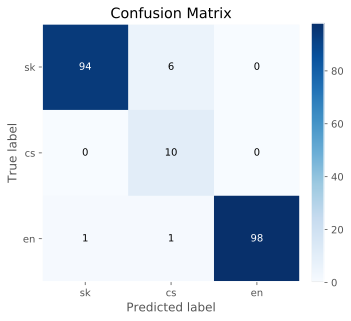

In [98]:
data_train_subwords= []
for sentence in sentences_train:
    data_train_subwords.append(split_into_subwords(sentence))

data_val_subwords = []
for sentence in sentences_val:
    data_val_subwords.append(split_into_subwords(sentence))

vectorizer = CountVectorizer()

x_train = vectorizer.fit_transform(data_train_subwords)
x_val = vectorizer.transform(data_val_subwords)

naive_classifier = MultinomialNB(alpha=1, fit_prior=False)
naive_classifier.fit(x_val,y_val)

predictions=naive_classifier.predict(x_train)

plot_confusion_matrix(y_train,predictions,['sk','cs','en'])

In [100]:
f1_score(y_train,predictions,average='weighted')

0.9657502990836323

In [101]:
joblib.dump(naive_classifier, 'Data/Models/final_model.joblib')
joblib.dump(vectorizer, 'Data/Vectorizers/final_model.joblib')


['Data/Vectorizers/final_model.joblib']